In [2]:
!pip install datasets transformers torch

In [6]:
#inport Cfar10 from HuggingFace

from datasets import load_dataset
dataset_train = load_dataset("cifar10", split="train")


In [7]:
dataset_train

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [8]:
dataset_test=load_dataset("cifar10", split="test")

In [9]:
dataset_test

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [10]:
num_classes=len(set(dataset_train["label"]))
labels=dataset_train.features["label"]

num_classes,labels

(10,
 ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None))

In [11]:
dataset_train[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

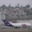

In [12]:
dataset_train[0]["img"]

In [13]:
dataset_train[0]["label"],labels.names[dataset_train[0]["label"]]

(0, 'airplane')

In [11]:
from transformers import ViTFeatureExtractor,AutoImageProcessor
#import model
model_name_or_path="google/vit-base-patch16-224-in21k"
feature_extractor=ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [14]:
feature_extractor

ViTFeatureExtractor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [15]:
example= feature_extractor(dataset_train[0]["img"],return_tensors="pt")
example

{'pixel_values': tensor([[[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.3647,  0.3647,  0.3647],
          [ 0

In [16]:
example["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [17]:
dataset_train[0]["img"].size

(32, 32)

In [18]:
import torch

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
def preprocess(batch):
    #takes list of pil image and trun them to pixel values
    inputs=feature_extractor([x for x in batch["img"]],return_tensors="pt")
    inputs["labels"]=batch["label"]
    return inputs


In [20]:
prepared_train=dataset_train.with_transform(preprocess)
prepared_train

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [21]:
prepared_test=dataset_test.with_transform(preprocess)
prepared_test

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [20]:
def collate_fn(batch):
    return {
        "pixel_values":torch.stack([x["pixel_values"] for x in batch]),
        "labels":torch.tensor([x["labels"] for x in batch])
    }

In [21]:
!pip install datasets evaluate

In [22]:
import numpy as np
from evaluate import load # Import load instead of load_metric
#from datasets import load_metric #This line is no longer needed

metric = load("accuracy") # Use load to get the accuracy metric
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1),
                          references=p.label_ids)

In [22]:
from os import remove
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="./cifar",
                                  per_device_train_batch_size=16,
                                  evaluation_strategy="steps",
                                  num_train_epochs=4,
                                  #fp16=True,
                                  save_steps=1000,
                                  eval_steps=1000,
                                  logging_steps=100,
                                  learning_rate=2e-4,
                                  save_total_limit=2,
                                  remove_unused_columns=False,
                                  push_to_hub=False,
                                  load_best_model_at_end=True)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
from transformers import ViTForImageClassification

labels = dataset_train.features["label"].names
model = ViTForImageClassification.from_pretrained(model_name_or_path, num_labels=len(labels))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [25]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  data_collator=collate_fn,
                  compute_metrics=compute_metrics,
                  train_dataset=prepared_train,
                  eval_dataset=prepared_test,
                  tokenizer=feature_extractor)

<ipython-input-25-df4d05aa1b1c>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [26]:
train_results= trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()
#

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: alignb. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss,Validation Loss,Accuracy
1000,0.225000,0.262592,0.926400
2000,0.228300,0.209296,0.936200
3000,0.237600,0.179788,0.945600


Step,Training Loss,Validation Loss,Accuracy
1000,0.225000,0.262592,0.926400
2000,0.228300,0.209296,0.936200
3000,0.237600,0.179788,0.945600
4000,0.112700,0.183314,0.947600
5000,0.101100,0.140200,0.962000
6000,0.058000,0.150317,0.960600
7000,0.050900,0.163900,0.961100
8000,0.054500,0.155143,0.963300
9000,0.034700,0.129579,0.969700
10000,0.004200,0.129499,0.971700


***** train metrics *****
  epoch                    =           4.0
  total_flos               = 14435042795GF
  train_loss               =        0.1108
  train_runtime            =    2:29:52.44
  train_samples_per_second =        22.241
  train_steps_per_second   =          1.39


In [27]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)
#

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.976
  eval_loss               =     0.1209
  eval_runtime            = 0:01:58.76
  eval_samples_per_second =     84.203
  eval_steps_per_second   =     10.525


In [ ]:
#show the first image of testing dataset
image=prepared_test["img"][0].resize((224,224))
image


In [ ]:
actual_label=dataset_test["label"][0]
labels = dataset_test.features["label"].names

actual_label,labels

In [2]:
from transformers import ViTForImageClassification , ViTFeatureExtractor

model_name_or_path = "LaCarnevali/vit-cifar10"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [ ]:
image=prepared_test["img"][0].resize((224,224))
inputs= feature_extractor(image,return_tensors="pt")

with torch.no_grad():
    logits=model_finetuned(**inputs).logits

predicted_label=logits.argmax(-1).item()
labels= dataset_test.features["label"]
predicted_label,labels[predicted_label]